In [1]:
import numpy as np
import pickle as pk
from matplotlib import pyplot as plt
import scipy.stats as stats
import cartopy
from sklearn.metrics import r2_score as r2_score
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl
mpl.rc('font',size=16,**{'family':'sans-serif','sans-serif':['Arial']})

In [6]:
path = '/Volumes/eSSD0/Papers/JoC_gFBK/Data/'
pi = pk.load(open(path+'Outputs/b.e12.pi-control.T31_g37.ctl.2_diag_grid.pk','rb'))
geo = pk.load(open(path+'Outputs/b.e12.1pyCO2.T31_g37.ctl.closed.2_diag_grid.pk','rb'))['isccp']
py1 = pk.load(open(path+'Outputs/b.e12.1pyCO2.T31_g37.ctl.open.2_diag_grid.pk','rb'))['isccp']

geo = np.nansum(geo,axis=(2,3))
py1 = np.nansum(py1,axis=(2,3))

In [15]:
control = np.nanmean(
    np.nansum(pi['isccp'][-30:], axis=(2,3)),axis=(0,1))

In [16]:
resp_geo = np.nanmean(geo[-20:],axis=(0,1))
resp_1pyCO2 = np.nanmean(py1[-20:],axis=(0,1))

delta = {
    'geo':resp_geo-control,
    'co2':resp_1pyCO2-control
}

In [17]:
lat = pi['lat']
lon = pi['lon']

y = lat*np.pi/180
coslat = np.cos(y)
coslat = np.tile(coslat[None:,None],(1,lon.size))

In [18]:
tas_gam = {}
tas_zm = {}
for keys in delta.keys():
    tas_gam[keys] = np.average(delta[keys],weights=coslat)
    tas_zm[keys] = np.nanmean(delta[keys],axis=1)

In [19]:
tas_plot = {}
for keys in delta.keys():
    tas_plot[keys] = np.concatenate((delta[keys][:,48:],delta[keys][:,:48]),axis=1)
    tas_plot[keys],lon_cyc = add_cyclic_point(tas_plot[keys],lon)

/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/johnvirgin/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:336: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '


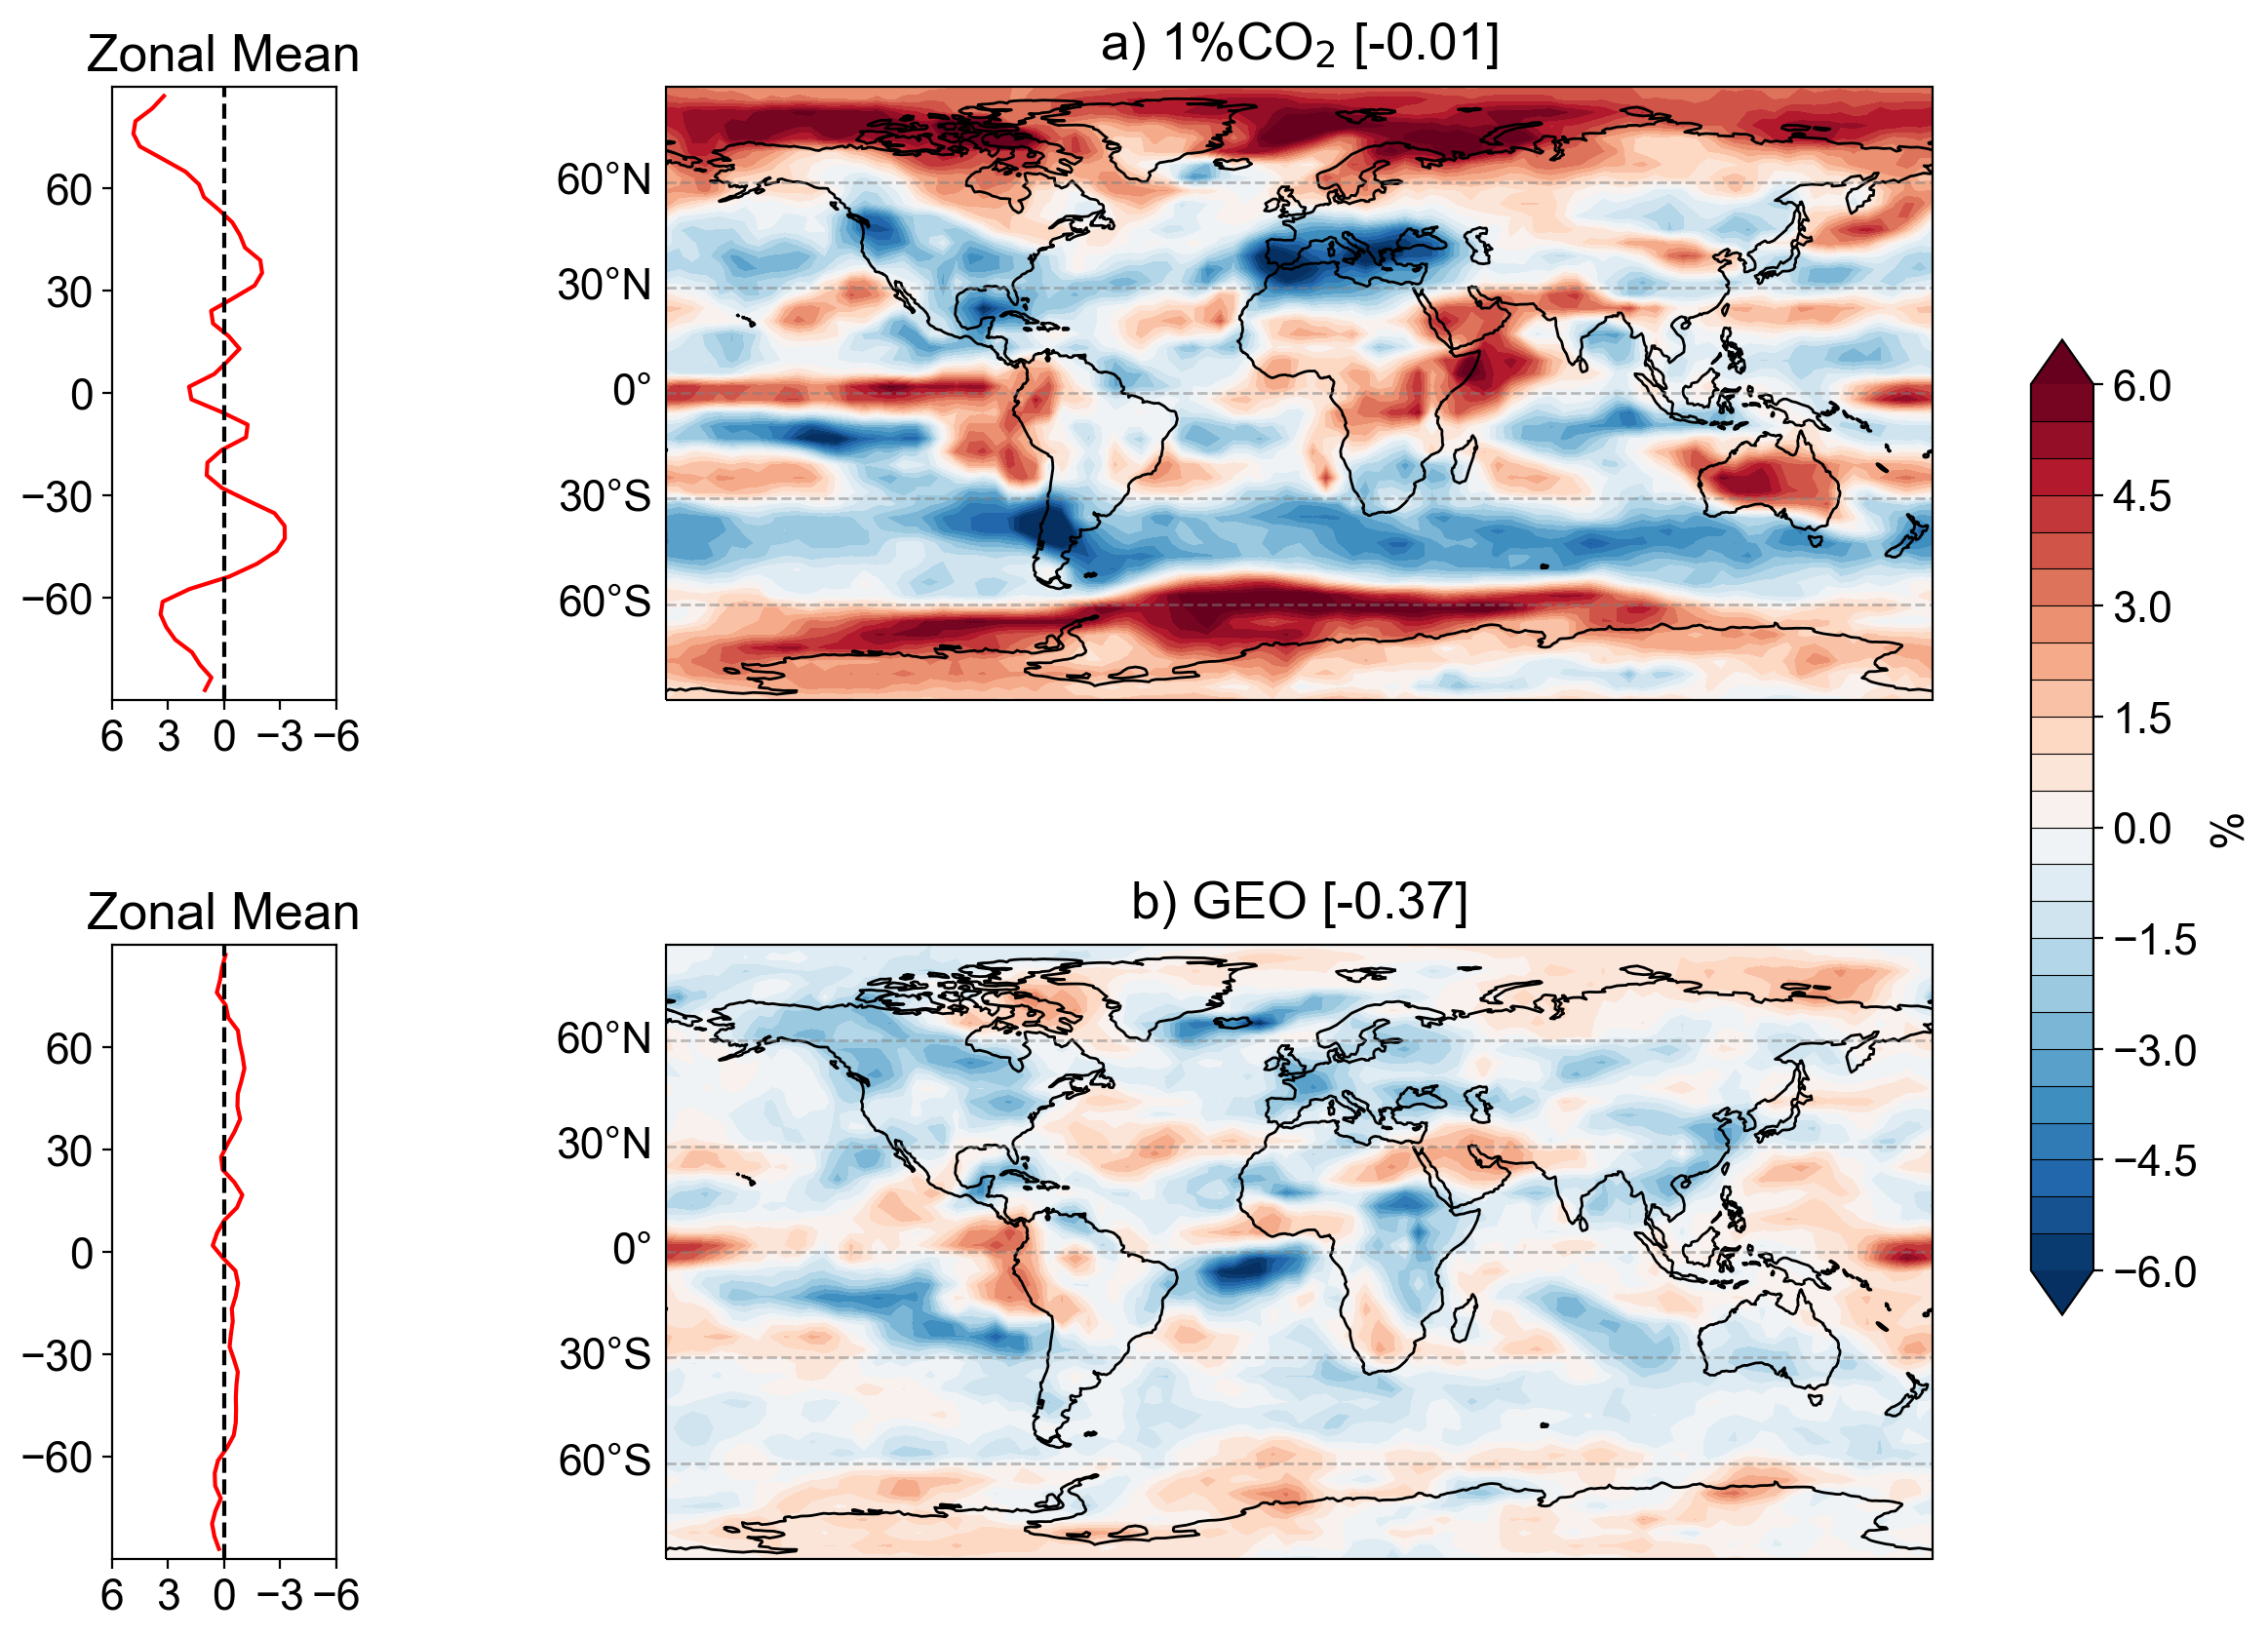

In [22]:
color = plt.cm.RdBu_r

bounds = np.arange(-6,6.1,0.5)

fig = plt.figure(figsize=(16,10),dpi=200)
plt.subplot2grid((2, 8), (0, 0), rowspan=1)
plt.title('Zonal Mean')
plt.plot(tas_zm['co2'],lat, color='red')
plt.ylim(-90,90)
plt.xlim(-3,3)
plt.yticks(np.arange(-60,61,30))
plt.xticks(np.arange(-6,6.1,3))
plt.axvline(0,color='k',linestyle='--')
plt.gca().invert_xaxis()

plt.subplot2grid((2, 8), (1, 0), rowspan=1)
plt.title('Zonal Mean')

plt.plot(tas_zm['geo'],lat, color='red')
plt.ylim(-90,90)
plt.xlim(-3,3)
plt.yticks(np.arange(-60,61,30))
plt.xticks(np.arange(-6,6.1,3))
plt.axvline(0,color='k',linestyle='--')
plt.gca().invert_xaxis()
#plt.suptitle('Annual Mean')
ax0 = plt.subplot2grid((2, 8), (0, 1), colspan=7, rowspan=1,projection=ccrs.PlateCarree())
ax0.set_title(f"a) 1%CO$_{2}$ [{round(tas_gam['co2'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont0 = ax0.contourf(lon_cyc,lat,tas_plot['co2'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
ax0.coastlines()
g1 = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g1.xlabels_top = False
g1.ylabels_right = False
g1.xlines = False
g1.xlabels_bottom = False

ax1 = plt.subplot2grid((2, 8), (1, 1), colspan=7, rowspan=1,projection=ccrs.PlateCarree())
ax1.set_title(f"b) GEO [{round(tas_gam['geo'],2)}]",pad=10)
#ax0.set_extent([180, -180, -90, 90], ccrs.PlateCarree())
cont1 = ax1.contourf(lon_cyc,lat,tas_plot['geo'],bounds,cmap=color,extend='both',transform=ccrs.PlateCarree(central_longitude=180))
#ax1.contourf(lon_cyc,lat,binary_plot['sol'],colors='none',hatches=['','////'],transform=ccrs.PlateCarree(central_longitude=180))
ax1.coastlines()

g2 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')

g2.xlabels_top = False
g2.ylabels_right = False
g2.xlabels_bottom = False
g2.xlines = False

plt.subplots_adjust(hspace = 0.4,right=0.8)
cbar_ax = fig.add_axes([0.74, 0.25, 0.02, 0.5])
fig.colorbar(cont0, cax=cbar_ax,drawedges=True,label='%', orientation='vertical')

plt.savefig('cld_transient_map.png',bbox_inches='tight')